In [1]:
pip install ib_insync

In [144]:
from ib_insync import *

# Utilize an instance of IB
ib = IB()

# Connect to the IB server using await in front of the connectAsync method
try:
    await ib.connectAsync('127.0.0.1', 7497, clientId=1)
    print("Connected to Interactive Brokers API")
except Exception as e:
    print("There has is an error when connecting to IB API")

Connected to Interactive Brokers API


In [172]:
from ib_insync import *
import pytz
import pandas as pd
contract = Future('ES', '202406', 'CME')

await ib.qualifyContractsAsync(contract)

try:
    historical_data = await ib.reqHistoricalDataAsync(
        contract, endDateTime='', durationStr='30 D',
        barSizeSetting='1 hour', whatToShow='MIDPOINT', useRTH=True
    )
except Exception as e:
    print(f"An error occurred: {e}")

# Assuming 'historical_data' contains the historical data returned by reqHistoricalDataAsync

# Convert timestamps to the desired time zone (e.g., 'US/Eastern')
tz = pytz.timezone('US/Eastern')
for bar in historical_data:
    bar.date = bar.date.astimezone(tz)

# Convert historical data to DataFrame

df = pd.DataFrame([vars(bar) for bar in historical_data])
print(f"hiistorical data length {historical_data[len(historical_data)-1].close}")

print(df)
# market_data = ib.reqMktData(contract)
# print(market_data.bid)
# print(market_data.ask)

hiistorical data length 5049.0
                         date     open     high      low    close  volume  \
0   2024-03-20 09:30:00-04:00  5241.00  5243.50  5235.25  5237.75    -1.0   
1   2024-03-20 10:00:00-04:00  5237.75  5248.00  5236.50  5242.00    -1.0   
2   2024-03-20 11:00:00-04:00  5242.00  5246.50  5238.50  5242.00    -1.0   
3   2024-03-20 12:00:00-04:00  5242.00  5244.50  5236.50  5244.25    -1.0   
4   2024-03-20 13:00:00-04:00  5244.25  5244.25  5233.00  5237.25    -1.0   
..                        ...      ...      ...      ...      ...     ...   
235 2024-05-01 12:00:00-04:00  5046.50  5055.50  5042.25  5048.00    -1.0   
236 2024-05-01 13:00:00-04:00  5048.00  5057.75  5042.75  5053.50    -1.0   
237 2024-05-01 14:00:00-04:00  5053.50  5118.75  5051.25  5118.00    -1.0   
238 2024-05-01 15:00:00-04:00  5118.00  5126.50  5043.75  5046.25    -1.0   
239 2024-05-01 16:00:00-04:00  5046.25  5054.50  5045.00  5049.00    -1.0   

     average  barCount  
0       -1.0       

In [15]:
!pip install nest_asyncio

In [161]:
#E2
#Model construction and training
import nest_asyncio
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
nest_asyncio.apply()
class LSTMModel():
    ##
    def __init__(self, sequence_size=60, lstm_units=50, dense_units=25):
        self.sequence_size = sequence_size
        self.lstm_units = lstm_units
        self.dense_units = dense_units
        self.model = None
    # Preprocess data for model training
    def preprocess_data(self,filepath):
        data = pd.read_csv(filepath)
        features = data[['close', 'high', 'low', 'volume']].values # Fetch 4 columns from dataframe
        scaler = MinMaxScaler(feature_range=(0, 1))# Initialize scaler and normalize data to a range of 0 to 1.
        scaled_features = scaler.fit_transform(features)# Scaling each feature to the range (0,1) depending on the values 
        return scaled_features, scaler

    # Create sequences for LSTM training
    def create_sequences(self,data):
        inputSequence = [] #initialize input sequence
        targetSequence = [] #initialize target sequence
        sequence_size=60
        sequenceFormationLength = len(data) - sequence_size;
        for i in range(sequenceFormationLength): # iteration of data to form sequence    
            inputSequence.append(data[i:(i + sequence_size)]) # Appending a piece of data from i to i + sequence_size
            targetSequence.append(data[i + sequence_size, 0])# Used for prediction of the future close price
        return np.array(inputSequence), np.array(targetSequence)

    # Construct LSTM model 
    def build_lstm_model(self,input_shape):
        lstmLayerWithSequence = LSTM(50, return_sequences=True, input_shape=input_shape)
        self.model = Sequential([
            lstmLayerWithSequence, # LSTM layer with 50 neurons and returning full sequence which passed into the next layer as an input
            Dropout(0.2), # Dropout layer added to prevent overfitting
            LSTM(50), # Only the last output of the output sequence is returned and reduce dimensionality
            Dropout(0.2), # Dropout layer added to prevent overfitting
            Dense(25), # Fully-connected layer with 25 neurons that process the features fetched by the recurrent layers through interpretation and process of the output of prediction.
            Dense(1) # Fully-connected layer with 1 neuron that outputs the predicted value
        ])
        self.model.compile(optimizer='adam', loss='mean_squared_error') # Compile with Adam optimizer and configured the model for training
    # Train model
    def train(self, inputs, targets, validation_data, epochs=10, batch_size=32):
        return self.model.fit(inputs, targets, epochs=epochs, batch_size=batch_size, validation_data=validation_data)

    #Plotting model learning
    def plot_model_learning(self, history):
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        plt.show()

    # Function to inverse transform prices
    def inverse_transform_price(self, scaler, price, n_features):
        # Create a dummy array with the same number of features
        dummy = np.zeros((len(price), n_features))
        # Place the price in the correct column (assuming 'close' is the first column)
        dummy[:, 0] = price
        # Inverse transform and return the correct column
        return scaler.inverse_transform(dummy)[:, 0]

    # Plot predictions
    def plot_predictions(self, actual, predicted):
        plt.figure(figsize=(10, 5))
        plt.plot(actual, label='Actual Price', color='blue')
        plt.plot(predicted, label='Predicted Price', color='red')
        plt.title('Actual vs Predicted Prices')
        plt.xlabel('Time')
        plt.ylabel('Price')
        plt.legend()
        plt.show()
    def preprocess_and_save_data(self, data, filename):
        data.to_csv(filename, index=False)
    def predict(self, data):
        return self.model.predict(data)

In [210]:
# Prediction
def predict_security_price(model, scaler, data, current_price, available_funds, current_shares, total_cost, transaction_fee=2.25):
    scaled_data = data.reshape(1, 60, -1)  # Reshape scaled data passed into LSTM model as an input
    scaled_prediction = model.predict(scaled_data) # Model makes prediction based on scaled data
    # Focus only on close price, which is the first feature,use a dummy array for inverse transform
    dummy_features = np.zeros((1, 4))  # Use 4 features as per scaler fitting, one row and four columns, which correspond to the 4 features
    dummy_features[0, 0] = scaled_prediction[0][0]  # Predicted price goes into the position of close price
    
    predicted_price = scaler.inverse_transform(dummy_features)[0, 0]  # Inverse transform and fetch the close price, the scaled prediction is converted back to the original scale of the data
    return predicted_price, current_price
#Making trade decision based on predicted and current price
def trade_decision(predicted_price, current_price, available_funds):
    decision = "HOLD"
    shares = 0
    transaction_fee = 2.25
    available_funds = float(available_funds)
    
    if predicted_price > current_price:
        if (available_funds - transaction_fee)/ current_price >= 50:
            decision = "BUY"
            shares = 1
    elif predicted_price < current_price:
        decision = "SELL"
        shares = 1
        
    return decision, shares, predicted_price

2024-05-01 16:50:19.257078: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-01 16:50:19.258192: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-01 16:50:19.259536: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2024-05-01 16:50:19.471899: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-01 16:50:19.473130: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-01 16:50:19.474321: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6/6 [==============================] - ETA: 0s - loss: 0.1483

2024-05-01 16:50:23.140661: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-01 16:50:23.141741: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-01 16:50:23.143350: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6/6 [==============================] - 4s 166ms/step - loss: 0.1483 - val_loss: 0.0376
Epoch 2/50
6/6 [==============================] - 0s 31ms/step - loss: 0.0511 - val_loss: 0.0154
Epoch 3/50
6/6 [==============================] - 0s 36ms/step - loss: 0.0276 - val_loss: 0.0389
Epoch 4/50
6/6 [==============================] - 0s 31ms/step - loss: 0.0246 - val_loss: 0.0131
Epoch 5/50
6/6 [==============================] - 0s 33ms/step - loss: 0.0188 - val_loss: 0.0122
Epoch 6/50
6/6 [==============================] - 0s 33ms/step - loss: 0.0175 - val_loss: 0.0111
Epoch 7/50
6/6 [==============================] - 0s 31ms/step - loss: 0.0146 - val_loss: 0.0138
Epoch 8/50
6/6 [==============================] - 0s 32ms/step - loss: 0.0156 - val_loss: 0.0084
Epoch 9/50
6/6 [==============================] - 0s 31ms/step - loss: 0.0139 - val_loss: 0.0079
Epoch 10/50
6/6 [==============================] - 0s 32ms/step - loss: 0.0152 - val_loss: 0.0087
Epoch 11/50
6/6 [======================

2024-05-01 16:50:36.427022: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-01 16:50:36.429604: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-01 16:50:36.432272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 2s 17ms/step


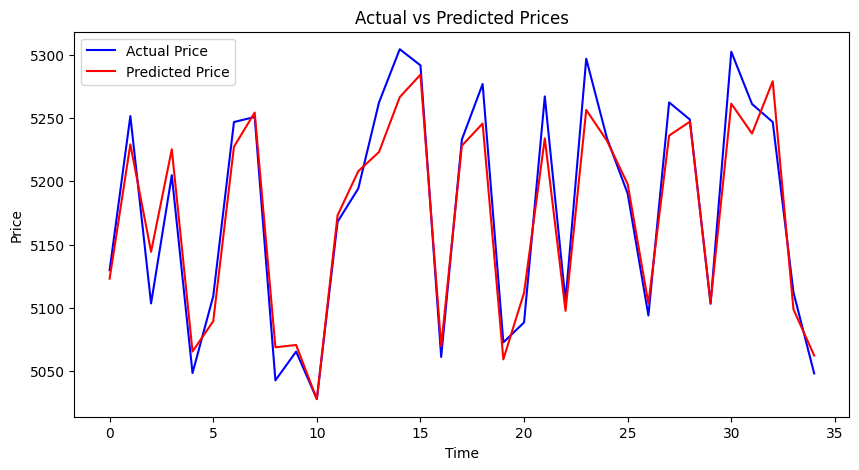

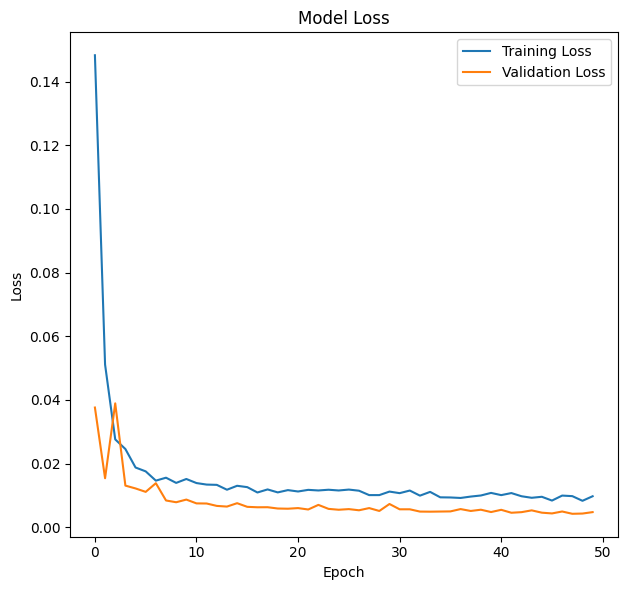

Error 10168, reqId 74: Requested market data is not subscribed. Delayed market data is not enabled., contract: Future(symbol='ES', lastTradeDateOrContractMonth='202406', exchange='CME')


1/1 [==============================] - 0s 43ms/step
Decision: BUY, Shares: 50, Predicted Price: 5061.671271242201
Order BUY for 50 shares has been filled.


In [197]:
async def fetchCurrentPrice():
    try:
        historical_data = await ib.reqHistoricalDataAsync(
            contract, endDateTime='', durationStr='30 D',
            barSizeSetting='1 hour', whatToShow='MIDPOINT', useRTH=True
        )
    except Exception as e:
        print(f"An error occurred: {e}")

    tz = pytz.timezone('US/Eastern')
    for bar in historical_data:
        bar.date = bar.date.astimezone(tz)

    df = pd.DataFrame([vars(bar) for bar in historical_data])
    price = historical_data[len(historical_data)-1].close
    return price


#Model building and price prediction and execution of trade decision
if __name__ == "__main__":
    model = LSTMModel(sequence_size=60, lstm_units=50, dense_units=25)
    model.preprocess_and_save_data(df, 'ib_es500_price_history.csv')
    filepath = 'ib_es500_price_history.csv'
    scaled_features, scaler = preprocess_data(filepath)
    inputs, targets = create_sequences(scaled_features)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    model = LSTMModel(sequence_size=60, lstm_units=50, dense_units=25)
    input_shape = x_train.shape[1], x_train.shape[2]
    model.build_lstm_model(input_shape)
    history = model.train(inputs, targets, (x_test, y_test), epochs=50, batch_size=32)
    # Generate and plot predictions
    
    predicted_scaled = model.predict(x_test)

    # Inverse transform predictions and actual values
    predicted_prices = inverse_transform_price(scaler, predicted_scaled.flatten(), 4)
    actual_prices = inverse_transform_price(scaler, y_test, 4)

    # Plotting function remains the same
    plot_predictions(actual_prices, predicted_prices)

    # Display training and validation loss
    plot_model_learning(history)

    

In [211]:
if __name__ == "__main__":
# Prediction and decision making
    positions = ib.positions()
    for pos in positions:
        if pos.contract.symbol == 'ES' and pos.contract.secType == 'FUT':
            current_shares = pos.position
    account_summary = await ib.accountSummaryAsync()
    # Fetch total cash remaining
    balance = next((item for item in account_summary if item.tag == 'TotalCashBalance'), None)
    available_funds = balance.value
    contract = Future('ES', '202406', 'CME')
    market_data = ib.reqMktData(contract, '', False, False)
    util.sleep(5)
    current_price = await fetchCurrentPrice()
#     (market_data.bid + market_data.ask) / 2
#     print(market_data.bid)#
#     print(market_data.ask)#
#     available_funds = balance.value
    total_cost = current_shares * current_price  # Simulated total cost of current shares
    
    # Utilize recent data for prediction
    recent_data = scaled_features[-60:]  # 60 timestamps
    predicted_price, current_price = predict_security_price(model, scaler, recent_data, current_price, available_funds, current_shares, total_cost)
    decision, shares, predicted_price = trade_decision(predicted_price, current_price, available_funds)
    print(f"Decision: {decision}, Shares: {shares}, Predicted Price: {predicted_price}")
    
    # Execute the decision
    if decision == "BUY":
        order = MarketOrder('BUY', shares)
        trade = ib.placeOrder(contract, order)
    elif decision == "SELL":
        order = MarketOrder('SELL', shares)
        trade = ib.placeOrder(contract, order)
    elif decision == "HOLD":
        print("Decision is to HOLD, no action taken.")

    ib.sleep(1)  # Time for the order to be executed

    print(f"Order {decision} for {shares} shares has been filled.")

ConnectionError: Not connected

In [115]:
from ib_insync import *

ib = IB()
ib.connect('127.0.0.1', 7497, clientId=1) 




Ticker(contract=Future(symbol='ES', lastTradeDateOrContractMonth='202306', exchange='CME'))


Error 200, reqId 3: No security definition has been found for the request, contract: Future(symbol='ES', lastTradeDateOrContractMonth='202306', exchange='CME')


In [135]:
import time

contract = Future('ES', '202406', 'CME')

market_data = ib.reqMktData(contract)

print(market_data.bid)

nan


Error 10168, reqId 23: Requested market data is not subscribed. Delayed market data is not enabled., contract: Future(symbol='ES', lastTradeDateOrContractMonth='202406', exchange='CME')
Error 1100, reqId -1: Connectivity between IBKR and Trader Workstation has been lost.
Error 1100, reqId -1: Connectivity between IBKR and Trader Workstation has been lost.
